Updated: 17/01/24

We compare start times determined by (regular) mismatch and spatial mismatch ('kicking in' of mode). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm

l_max = 4
n_max = 4

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

/data/rvnd2/python_envs/python-3.11-clone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [3]:
QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

200it [02:30,  1.33it/s]
200it [02:30,  1.32it/s]
200it [02:30,  1.33it/s]
200it [02:31,  1.32it/s]


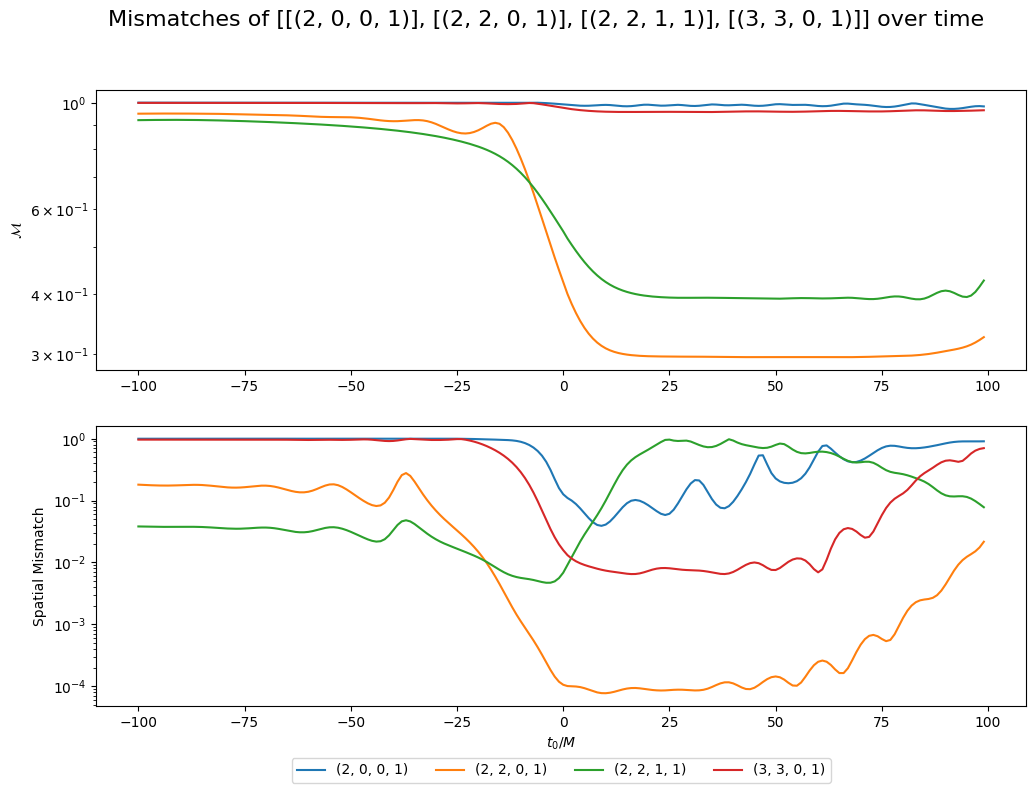

In [10]:
tstart = -50
tend = 100
tstep = 1

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)
times_list = np.arange(tstart, tend, tstep)

mappings = [[(2,2,0,1)], [(2,2,1,1)], [(3,3,0,1)]]

mm_array = np.zeros((len(mappings), 200))
sm_array = np.zeros((len(mappings), 200))

for i, mapping in enumerate(mappings):

    map = mapping[0]

    G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

    for j, step in tqdm(enumerate(times_list)):
        best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                                    sim.h, 
                                                    modes=QNMs,
                                                    Mf=sim.Mf,
                                                    chif=sim.chif_mag,
                                                    t0=step,
                                                    mapping_modes=mapping,
                                                    spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                    for m in np.arange(-l,l+1)])

        F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
        sm, _, _ = spatial_mismatch(F, G, num_points=100)
        sm_array[i][j] = sm 

        best_fit_r = qnmfits.multimode_ringdown_fit(sim.times, 
                                                sim.h, 
                                                modes=mapping,
                                                Mf=sim.Mf,
                                                chif=sim.chif_mag,
                                                t0=step,
                                                spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                for m in np.arange(-l,l+1)])
        
        mm_array[i][j] = best_fit_r['mismatch'] 


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig.suptitle(f'Mismatches of {mappings} over time', fontsize=16)

for i, mapping in enumerate(mappings):
    axs[0].plot(times_list, mm_array[i], label=f'{mapping[0]}')
    axs[1].plot(times_list, sm_array[i], label=f'{mapping[0]}')

axs[1].set_yscale('log')
axs[1].set_ylabel('Spatial Mismatch')

axs[0].set_yscale('log')
axs[0].set_ylabel('$\mathcal{M}$')

axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(mappings))
plt.xlabel('$t_0/M$')
plt.show()


150it [01:48,  1.38it/s]
150it [01:40,  1.49it/s]
150it [01:39,  1.51it/s]


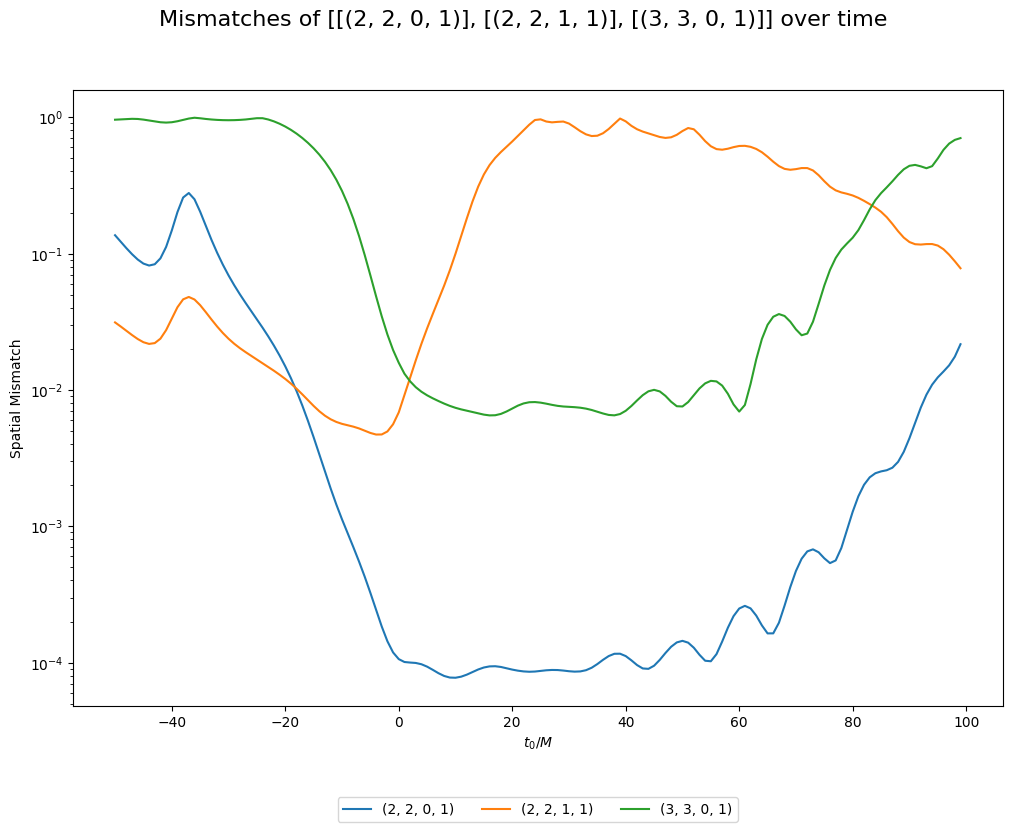

In [22]:
tstart = -50
tend = 100
tstep = 1

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)
times_list = np.arange(tstart, tend, tstep)

mappings = [[(2,2,0,1)], [(2,2,1,1)], [(3,3,0,1)]]

sm_array = np.zeros((len(mappings), 150))

for i, mapping in enumerate(mappings):

    map = mapping[0]
    G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

    for j, step in tqdm(enumerate(times_list)):
        best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                                    sim.h, 
                                                    modes=QNMs,
                                                    Mf=sim.Mf,
                                                    chif=sim.chif_mag,
                                                    t0=step,
                                                    mapping_modes=mapping,
                                                    spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                    for m in np.arange(-l,l+1)])

        F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
        sm, _, _ = spatial_mismatch(F, G, num_points=100)
        sm_array[i][j] = sm 

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
fig.suptitle(f'Mismatches of {mappings} over time', fontsize=16)

for i, mapping in enumerate(mappings):
    axs.plot(times_list, sm_array[i], label=f'{mapping[0]}')

axs.set_yscale('log')
axs.set_ylabel('Spatial Mismatch')

axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(mappings))
plt.xlabel('$t_0/M$')
plt.show()
